<a href="https://colab.research.google.com/github/k2345810/k2345810/blob/main/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Libraries
!pip install dask[complete]
!pip install imbalanced-learn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.2 MB/s eta 0:00:00


In [2]:
#Connecting to Google Drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [3]:
# Parallel Processing: Dask reads data in parallel, breaking it into smaller, manageable chunks, and then processes these
# chunks concurrently. This makes it possible to handle large datasets that
# don’t fit into memory.
import dask.dataframe as dd
file_path = '/content/drive/My Drive/CICIDS2018.csv'
ddf = dd.read_csv(file_path)

# Converting to Pandas DataFrame for processing
df = ddf.compute()

# Using 30% of the dataset
df = df.sample(frac=0.3, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
#feature reduction
# Encode the Label column
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

# Number of features before selection
print(f"Total features before selection: {df.shape[1] - 1}")

# Subsampling the data to make the calculation faster
sample_size = 200000
df_sample = df.sample(n=sample_size, random_state=42)

# Separate features and target for the subsample
X_sample = df_sample.drop('Label', axis=1)
y_sample = df_sample['Label']

# Train a RandomForest to get feature importances
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_sample, y_sample)
feature_importances = pd.Series(clf.feature_importances_, index=X_sample.columns)

# Sort features by importance
feature_importances = feature_importances.sort_values(ascending=False)
print("Feature importances from subsample:")
print(feature_importances)

# Select features with importance greater than a threshold
threshold = 0.01
selected_features = feature_importances[feature_importances > threshold].index
print(f"Selected Features: {selected_features}")

# Reduce full dataset to the selected features
df_reduced = df[selected_features.to_list() + ['Label']]

# Print total number of features after selection
print(f"Total features after selection: {df_reduced.shape[1] - 1}")  #exculding label columns

# Separate features and target for full dataset
X = df_reduced.drop('Label', axis=1)
y = df_reduced['Label']


Total features before selection: 78
Feature importances from subsample:
Init Fwd Win Byts    0.095170
Dst Port             0.081770
Fwd Seg Size Min     0.064813
Fwd Header Len       0.038531
Flow Pkts/s          0.038458
                       ...   
Fwd Byts/b Avg       0.000000
Bwd Byts/b Avg       0.000000
Fwd Blk Rate Avg     0.000000
Bwd Pkts/b Avg       0.000000
Bwd Blk Rate Avg     0.000000
Length: 78, dtype: float64
Selected Features: Index(['Init Fwd Win Byts', 'Dst Port', 'Fwd Seg Size Min', 'Fwd Header Len',
       'Flow Pkts/s', 'Flow IAT Min', 'Flow Duration', 'Flow IAT Max',
       'TotLen Fwd Pkts', 'Fwd IAT Mean', 'Fwd Pkts/s', 'Flow IAT Mean',
       'Fwd IAT Tot', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Pkt Len Mean',
       'Fwd Seg Size Avg', 'Fwd Pkt Len Max', 'Subflow Fwd Byts', 'Bwd Pkts/s',
       'Init Bwd Win Byts', 'Subflow Fwd Pkts', 'Flow IAT Std', 'Flow Byts/s',
       'Pkt Len Max', 'Bwd Pkt Len Std', 'Bwd Pkt Len Mean'],
      dtype='object')
Total features 

In [5]:
# skiped as no missing values found
#threshold = len(df_reduced) * 0.5
#df_reduced = df_reduced.dropna(thresh=threshold, axis=1)
#df_reduced = df_reduced.fillna(df_reduced.median())

# Separated features and target after handling missing values
X = df_reduced.drop('Label', axis=1)
y = df_reduced['Label']

In [6]:
# Normalize/Standardize Numerical Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Original number of features: 27
Reduced number of features after PCA: 11
Class distribution before handling imbalance:
Label
0     1338539
4       69002
6       57624
8       46247
1       28589
11      19494
14      18915
12      15965
9       13800
7        4152
10       1121
5         194
2          50
3          17
13          9
Name: count, dtype: int64
Class distribution after handling imbalance:
Label
0     1338539
11    1338539
7     1338539
4     1338539
8     1338539
6     1338539
14    1338539
1     1338539
9     1338539
12    1338539
5     1338539
10    1338539
3     1338539
2     1338539
13    1338539
Name: count, dtype: int64


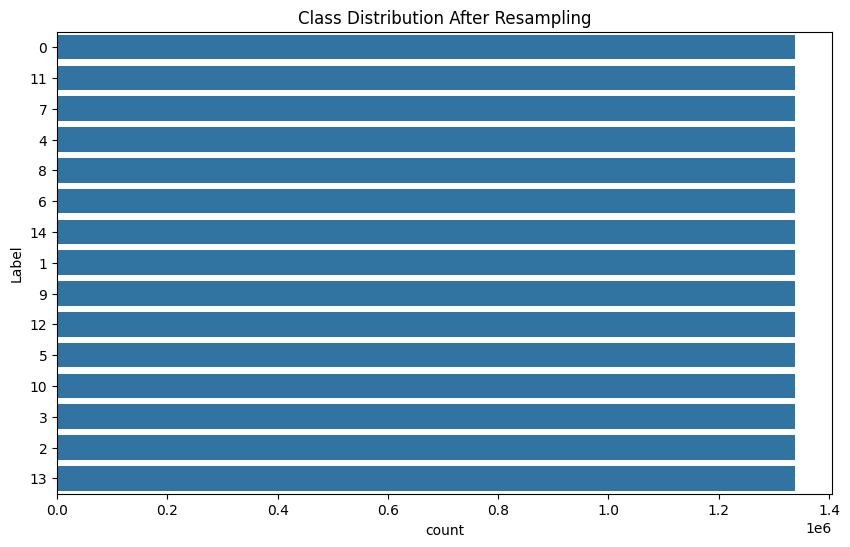

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Original number of features: {X_scaled.shape[1]}")
print(f"Reduced number of features after PCA: {X_pca.shape[1]}")

# Before handling class imbalance
print("Class distribution before handling imbalance:")
print(y.value_counts())

# Handling class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y)

# After handling class imbalance
print("Class distribution after handling imbalance:")
print(pd.Series(y_resampled).value_counts())

# Visualize class distribution after resampling
plt.figure(figsize=(10, 6))
sns.countplot(y=y_resampled, order=pd.Series(y_resampled).value_counts().index)
plt.title('Class Distribution After Resampling')
plt.show()


##LSTM Model

Epoch 1/10
235289/235291 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.8820
Epoch 1: val_loss improved from inf to 0.18578, saving model to best_lstm_model_fold1.keras
235291/235291 [==============================] - 1425s 6ms/step - loss: 0.2108 - accuracy: 0.8820 - val_loss: 0.1858 - val_accuracy: 0.8921 - lr: 0.0010
Epoch 2/10
235283/235291 [============================>.] - ETA: 0s - loss: 0.1907 - accuracy: 0.8893
Epoch 2: val_loss improved from 0.18578 to 0.18056, saving model to best_lstm_model_fold1.keras
235291/235291 [==============================] - 1401s 6ms/step - loss: 0.1907 - accuracy: 0.8893 - val_loss: 0.1806 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 3/10
235283/235291 [============================>.] - ETA: 0s - loss: 0.1876 - accuracy: 0.8911
Epoch 3: val_loss improved from 0.18056 to 0.17958, saving model to best_lstm_model_fold1.keras
235291/235291 [==============================] - 1383s 6ms/step - loss: 0.1876 - accuracy: 0.8911 - val_

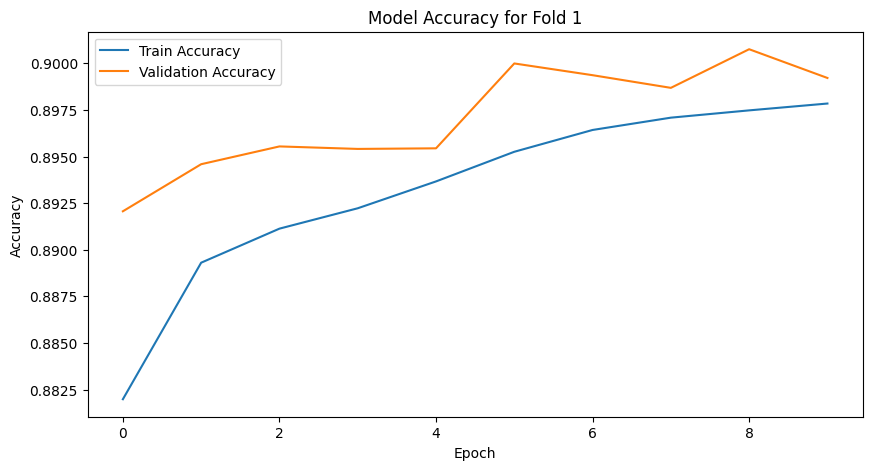

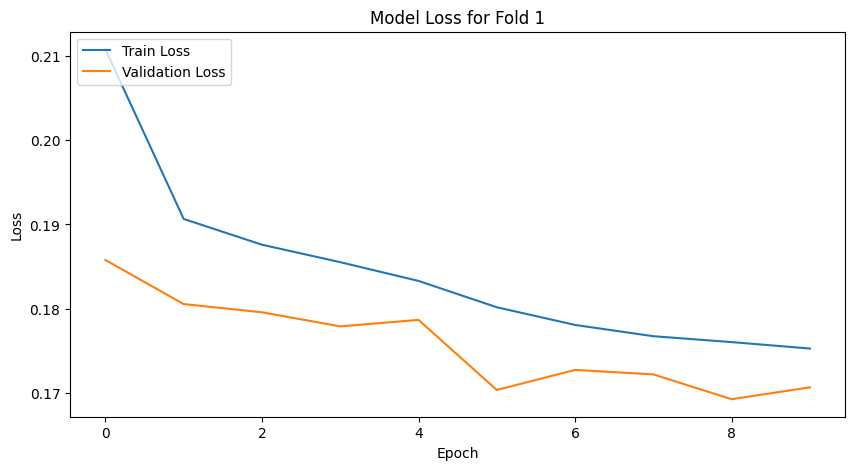

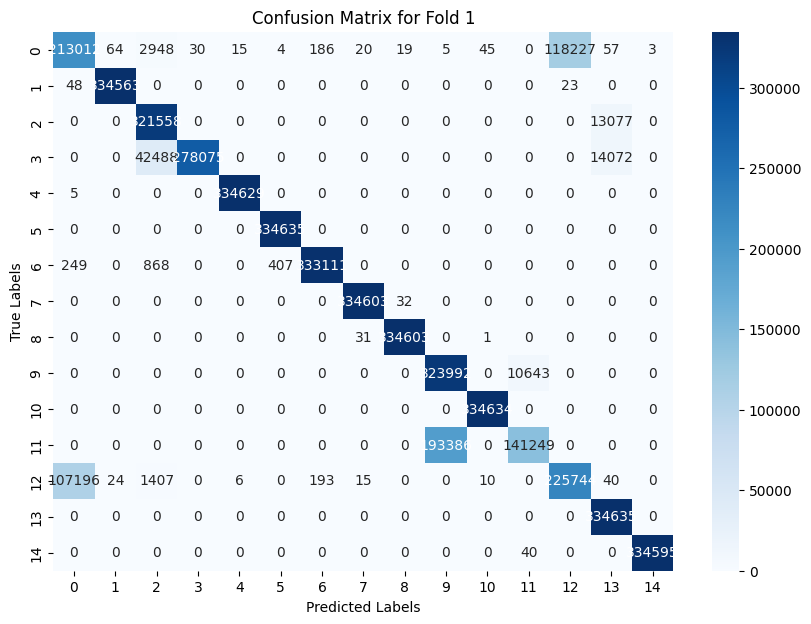

Epoch 1/10
235288/235291 [============================>.] - ETA: 0s - loss: 0.2113 - accuracy: 0.8816
Epoch 1: val_loss improved from inf to 0.18729, saving model to best_lstm_model_fold2.keras
235291/235291 [==============================] - 1466s 6ms/step - loss: 0.2113 - accuracy: 0.8816 - val_loss: 0.1873 - val_accuracy: 0.8908 - lr: 0.0010
Epoch 2/10
235285/235291 [============================>.] - ETA: 0s - loss: 0.1914 - accuracy: 0.8892
Epoch 2: val_loss improved from 0.18729 to 0.18086, saving model to best_lstm_model_fold2.keras
235291/235291 [==============================] - 1441s 6ms/step - loss: 0.1914 - accuracy: 0.8892 - val_loss: 0.1809 - val_accuracy: 0.8939 - lr: 0.0010
Epoch 3/10
235290/235291 [============================>.] - ETA: 0s - loss: 0.1878 - accuracy: 0.8910
Epoch 3: val_loss improved from 0.18086 to 0.17832, saving model to best_lstm_model_fold2.keras
235291/235291 [==============================] - 1441s 6ms/step - loss: 0.1878 - accuracy: 0.8910 - val_

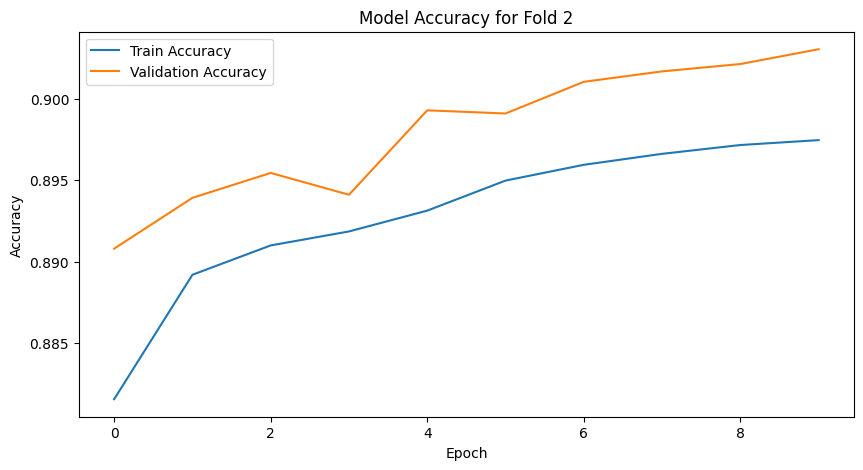

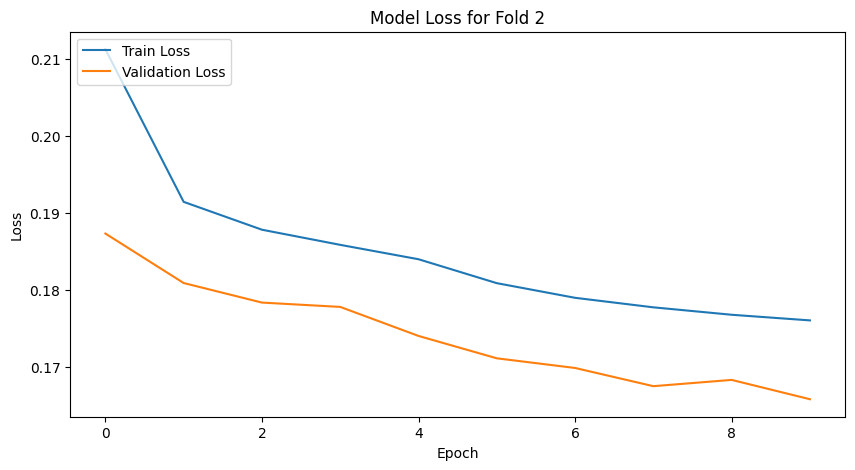

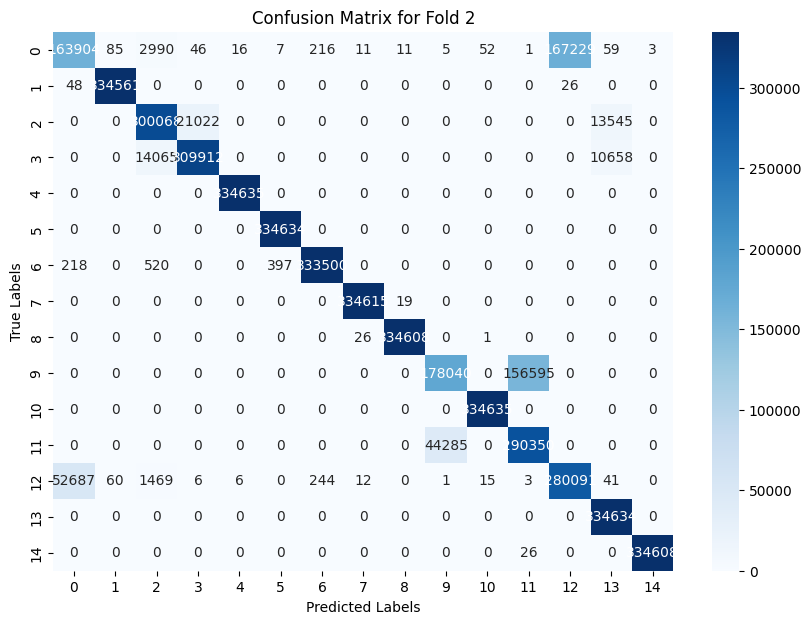

Epoch 1/10
235287/235291 [============================>.] - ETA: 0s - loss: 0.2104 - accuracy: 0.8829
Epoch 1: val_loss improved from inf to 0.18477, saving model to best_lstm_model_fold3.keras
235291/235291 [==============================] - 1439s 6ms/step - loss: 0.2104 - accuracy: 0.8829 - val_loss: 0.1848 - val_accuracy: 0.8923 - lr: 0.0010
Epoch 2/10
235283/235291 [============================>.] - ETA: 0s - loss: 0.1905 - accuracy: 0.8897
Epoch 2: val_loss improved from 0.18477 to 0.18057, saving model to best_lstm_model_fold3.keras
235291/235291 [==============================] - 1437s 6ms/step - loss: 0.1905 - accuracy: 0.8897 - val_loss: 0.1806 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 3/10
235285/235291 [============================>.] - ETA: 0s - loss: 0.1870 - accuracy: 0.8913
Epoch 3: val_loss improved from 0.18057 to 0.17891, saving model to best_lstm_model_fold3.keras
235291/235291 [==============================] - 1440s 6ms/step - loss: 0.1870 - accuracy: 0.8913 - val_

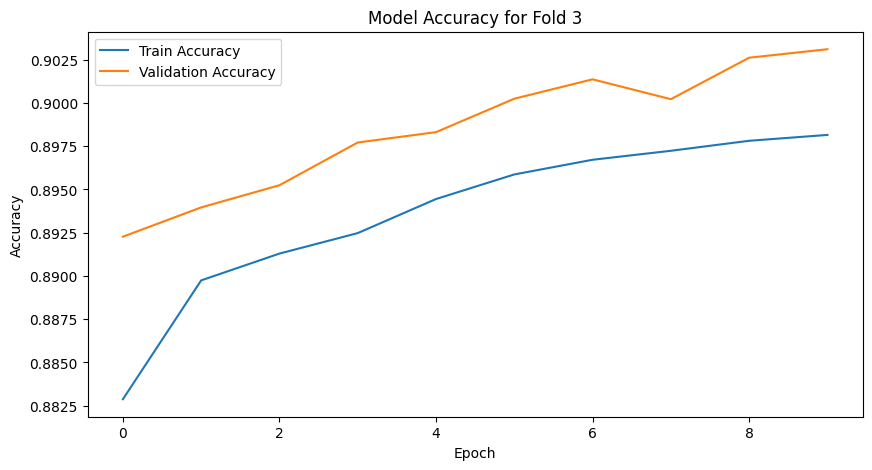

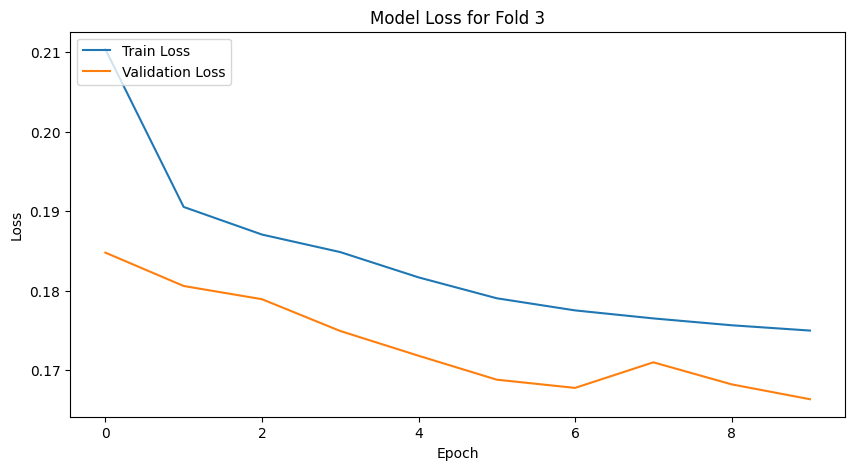

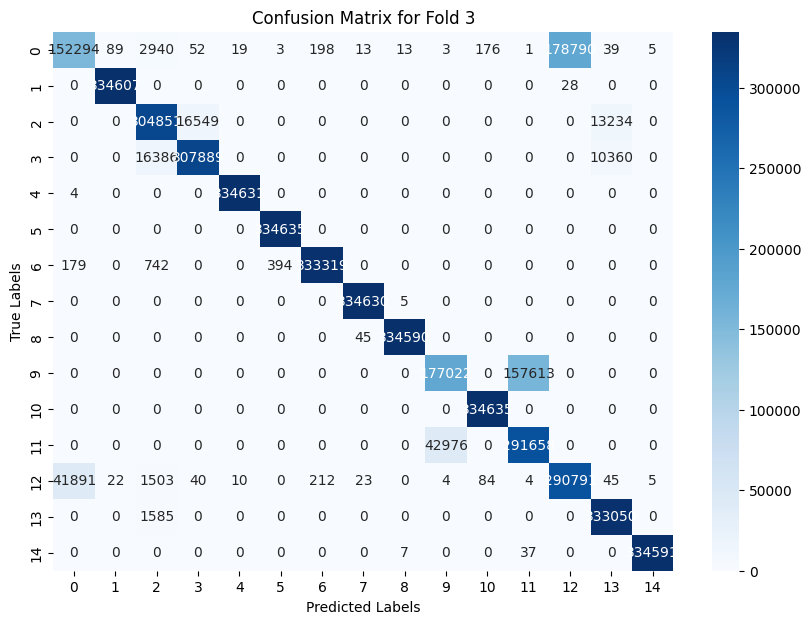

Epoch 1/10
235284/235291 [============================>.] - ETA: 0s - loss: 0.2100 - accuracy: 0.8824
Epoch 1: val_loss improved from inf to 0.18883, saving model to best_lstm_model_fold4.keras
235291/235291 [==============================] - 1466s 6ms/step - loss: 0.2100 - accuracy: 0.8824 - val_loss: 0.1888 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 2/10
235285/235291 [============================>.] - ETA: 0s - loss: 0.1906 - accuracy: 0.8894
Epoch 2: val_loss improved from 0.18883 to 0.18034, saving model to best_lstm_model_fold4.keras
235291/235291 [==============================] - 1416s 6ms/step - loss: 0.1906 - accuracy: 0.8894 - val_loss: 0.1803 - val_accuracy: 0.8950 - lr: 0.0010
Epoch 3/10
235288/235291 [============================>.] - ETA: 0s - loss: 0.1873 - accuracy: 0.8912
Epoch 3: val_loss improved from 0.18034 to 0.17829, saving model to best_lstm_model_fold4.keras
235291/235291 [==============================] - 1426s 6ms/step - loss: 0.1873 - accuracy: 0.8912 - val_

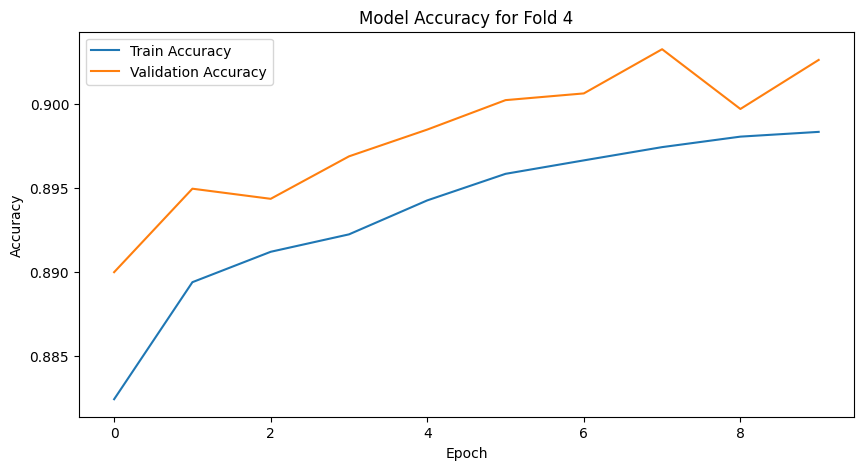

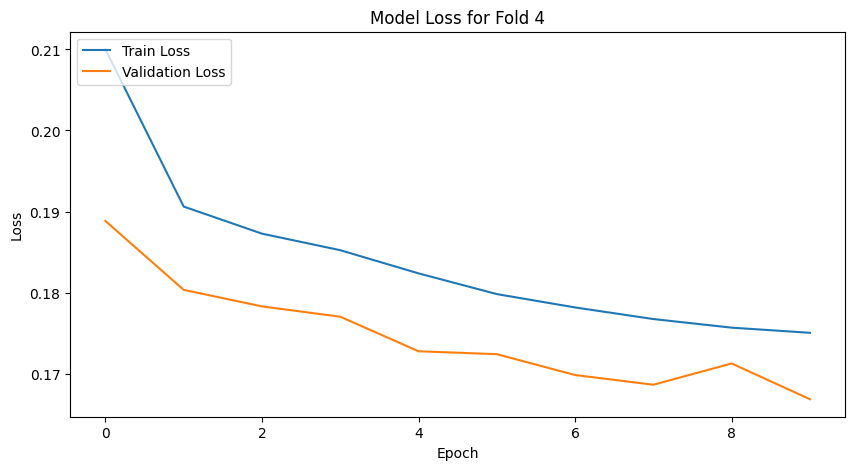

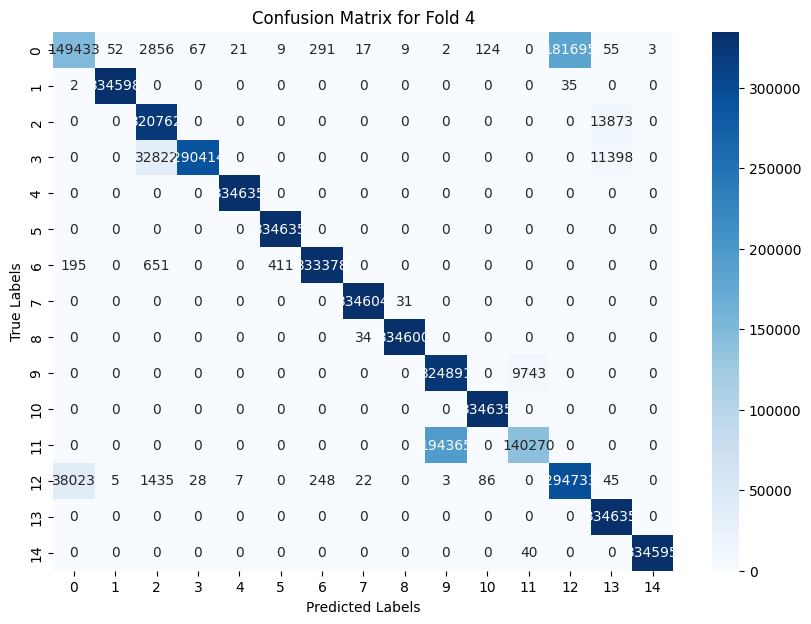

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.17071576416492462 - Accuracy: 89.92167115211487% - Precision: 0.9112619151357869 - Recall: 0.8992166983230674 - F1 Score: 0.8956468116894738 - ROC-AUC: 0.9460089754715639
------------------------------------------------------------------------
> Fold 2 - Loss: 0.16572460532188416 - Accuracy: 90.30333757400513% - Precision: 0.9091814732441599 - Recall: 0.9030333770891684 - F1 Score: 0.9002338701245769 - ROC-AUC: 0.9480536333320593
------------------------------------------------------------------------
> Fold 3 - Loss: 0.16632141172885895 - Accuracy: 90.31126499176025% - Precision: 0.9109532381627065 - Recall: 0.903112667523455 - F1 Score: 0.8996627626161733 - ROC-AUC: 0.9480960757410554
------------------------------------------------------------------------
> Fold 4 - Loss: 0.16680878400802612 - Accuracy: 90

In [8]:
#LSTM_Model_with_KFold_Validation
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
X_resampled_lstm = X_resampled.reshape((X_resampled.shape[0], 1, X_resampled.shape[1]))

# Initialize K-fold cross-validation
num_folds = 4
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_score_per_fold = []
roc_auc_per_fold = []
conf_matrices = []

for train, test in kfold.split(X_resampled_lstm, y_resampled):
    # LSTM model architecture
    lstm_model = Sequential(name="Complex_LSTM_Model_with_KFold_Validation")
    lstm_model.add(LSTM(128, input_shape=(1, X_resampled.shape[1]), return_sequences=True))
    lstm_model.add(Dropout(0.3))
    lstm_model.add(LSTM(64))
    lstm_model.add(Dropout(0.3))
    lstm_model.add(Dense(len(np.unique(y_resampled)), activation='softmax'))

    # Compile
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    lstm_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'best_lstm_model_fold{fold_no}.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

    # Fit data to model
    history = lstm_model.fit(X_resampled_lstm[train], y_resampled[train],
                             batch_size=64,
                             epochs=10,
                             validation_data=(X_resampled_lstm[test], y_resampled[test]),
                             callbacks=[early_stopping, model_checkpoint, reduce_lr])

    # Evaluate the model
    scores = lstm_model.evaluate(X_resampled_lstm[test], y_resampled[test], verbose=0)
    print(f'Score for fold {fold_no}: {lstm_model.metrics_names[0]} of {scores[0]}; {lstm_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Predictions and metrics
    y_pred = np.argmax(lstm_model.predict(X_resampled_lstm[test]), axis=1)
    precision = precision_score(y_resampled[test], y_pred, average='weighted')
    recall = recall_score(y_resampled[test], y_pred, average='weighted')
    f1 = f1_score(y_resampled[test], y_pred, average='weighted')
    roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_resampled[test]), tf.keras.utils.to_categorical(y_pred), multi_class='ovr')

    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_score_per_fold.append(f1)
    roc_auc_per_fold.append(roc_auc)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_resampled[test], y_pred)
    conf_matrices.append(conf_matrix)

    # Plotting training & validation accuracy values
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy for Fold {fold_no}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plotting training & validation loss values
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss for Fold {fold_no}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Enhanced Confusion Matrix Visualization
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_resampled), yticklabels=np.unique(y_resampled))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for Fold {fold_no}')
    plt.show()

    fold_no += 1

#  Average scores
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - Precision: {precision_per_fold[i]} - Recall: {recall_per_fold[i]} - F1 Score: {f1_score_per_fold[i]} - ROC-AUC: {roc_auc_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> Precision: {np.mean(precision_per_fold)}')
print(f'> Recall: {np.mean(recall_per_fold)}')
print(f'> F1 Score: {np.mean(f1_score_per_fold)}')
print(f'> ROC-AUC: {np.mean(roc_auc_per_fold)}')
print('------------------------------------------------------------------------')
